In [ ]:
from PIL import Image
import numpy as np
import cv2

In [13]:
def crop_margin_legacy(img: Image.Image) -> Image.Image:
    """
    Source Nougat method
    """
    data = np.array(img.convert("L"))
    data = data.astype(np.uint8)
    max_val = data.max()
    min_val = data.min()
    if max_val == min_val:
        return img
    data = (data - min_val) / (max_val - min_val) * 255
    gray = 255 * (data < 200).astype(np.uint8)

    # Likely slow
    coords = cv2.findNonZero(gray)  # Find all non-zero points (text)
    a, b, w, h = cv2.boundingRect(coords)  # Find minimum spanning bounding box
    return img.crop((a, b, w + a, h + b))

In [ ]:
# @staticmethod
def crop_margin(img: Image.Image) -> Image.Image:
    """Updated margin cropper w/o cv2-depencency"""
    # grayscale → ndarray
    data = np.asarray(img.convert("L"), dtype=np.uint8)

    # normalize contrast like your original code
    dmin, dmax = int(data.min()), int(data.max())
    if dmax == dmin:  # completely flat image
        return img
    data = ((data.astype(np.float32) - dmin) / (dmax - dmin) * 255.0).astype(np.uint8)

    # threshold: True = foreground (text/dark), mimics (data < 200)
    mask = data < 200
    if not mask.any():
        return img

    # find tight bounding box (rows/cols where any foreground exists)
    # - formerly v2.findNonZero() & cv2.boundingRect()
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    y_idxs = np.where(rows)[0]
    x_idxs = np.where(cols)[0]

     # PIL crop is exclusive (+1)
    top, bottom = int(y_idxs[0]), int(y_idxs[-1]) + 1
    left, right = int(x_idxs[0]), int(x_idxs[-1]) + 1

    return img.crop((left, top, right, bottom))

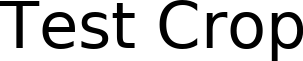

In [17]:
snapped_image_legacy = crop_margin_legacy(Image.open("test_text_with_margins.png"))
snapped_image_legacy

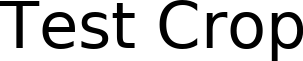

In [18]:
new_image = crop_margin(Image.open("test_text_with_margins.png"))
new_image

In [30]:
# Comparison
a = np.asarray(snapped_image_legacy.convert("RGB"), dtype=np.int16)
b = np.asarray(new_image.convert("RGB").resize(a.shape[1::-1]), dtype=np.int16)

# signed difference per channel
diff = a - b
assert np.max(diff) == 0, "Images exactly identical"

In [ ]:
new_image.to